# Momentum 전략 데모

In [8]:
import sys

from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns

In [51]:
import gaps_config as gcfg

In [24]:
import warnings

warnings.filterwarnings(action='ignore')

In [9]:
# 경로설정

CWD = Path.cwd()
WORKSPACE_PATH = CWD.parent
COMMON_PATH = WORKSPACE_PATH / 'common'
DATA_PATH = WORKSPACE_PATH / 'data'
FONT_PATH = COMMON_PATH / 'fonts' / 'NanumGothic.ttf'

In [31]:
font_prop = font_manager.FontProperties(fname=FONT_PATH)
print( font_prop.get_name() )

font_manager.fontManager.addfont(str(FONT_PATH))
rc('font', family=font_prop.get_name())

NanumGothic


In [11]:
sys.path.append(str(COMMON_PATH))

In [12]:
import fn_loader as fn
import fn_config as fncfg
import gaps_config as gcfg

from validator import *
from backtest import Backtest

## Import Data

In [13]:
# loader 생성 (데이터 로드 + multi index로 전처리)
# use_alias=True 일 경우 긴 ETF명 대신 축약한 단어 사용
pricevolume1 = fn.FnDataLoader('DBGAPS2024_pricevolume1_240826.xlsx', use_alias=True)  

In [14]:
return_df = pricevolume1.get_data('return') / 100 # 

## Momentum Alpha

### Momentum 1: 12개월 mean - 1개월 mean

In [17]:
momentum12m = return_df.rolling(252).mean()
momentum1m = return_df.rolling(21).mean()

momentum_v1 = momentum1m - momentum12m

In [19]:
momentum_v1.dropna(inplace=True)

In [20]:
# apply constraint

constraint_momentum_v1 = ConstraintHandler.apply_constraints(
    weights_df=momentum_v1,
    objective_function=obj_mse,
)

In [21]:
# Alpha validation

momentum_v1_alpha = Alpha('jaepil', constraint_momentum_v1)

In [22]:
backtest = Backtest(momentum_v1_alpha, return_df)

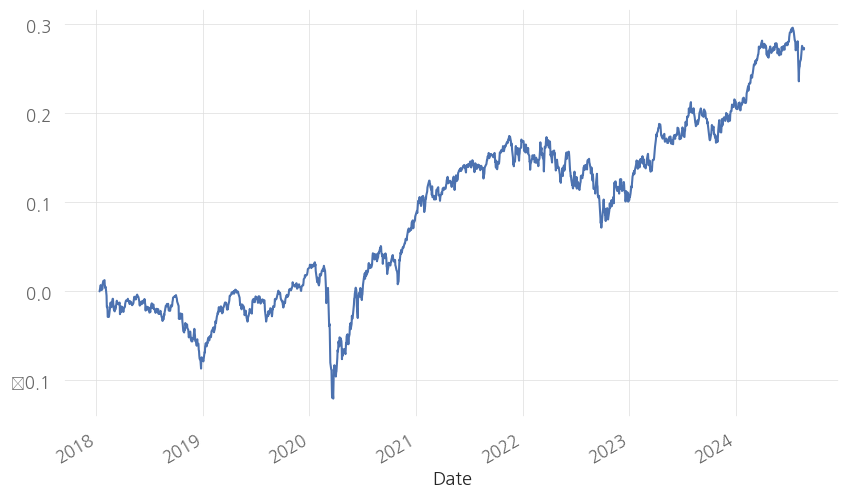

In [32]:
backtest.plot_cum_return()

In [37]:
stats = [
    'sharpe',
    'avg_return',
    'max_drawdown',
    'win_rate',
]

for stat in stats:
    print(f'{stat}: {backtest.get_stat(stat)}')

sharpe: 0.5782963099168771
avg_return: 0.0001576645983666537
max_drawdown: -0.1483333567825753
win_rate: 0.5491400491400491


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


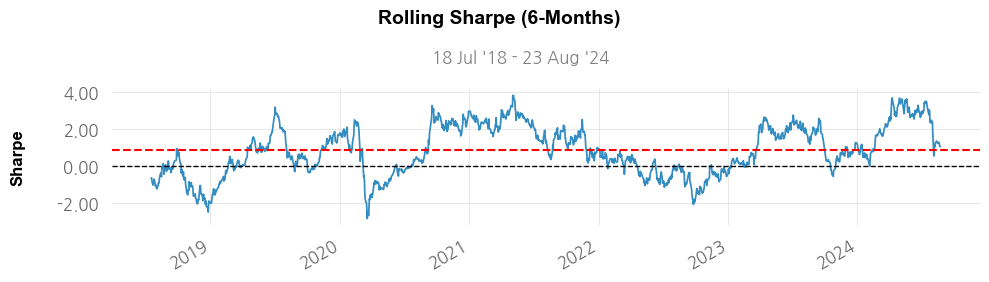

In [39]:
backtest.get_plot('rolling_sharpe')

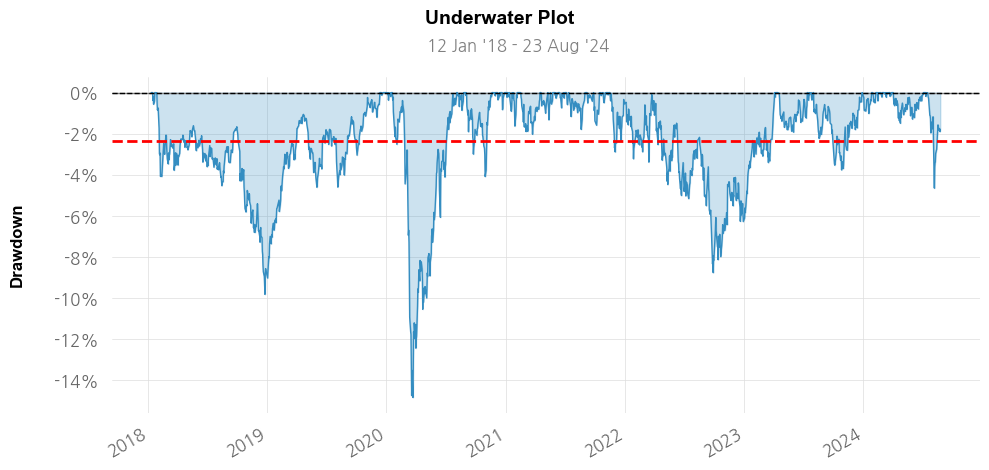

In [40]:
backtest.get_plot('drawdown')

### Momentum 2: 단기모멘텀 63일

In [41]:
momentum_v2 = return_df.rolling(63).mean()

In [42]:
momentum_v2.dropna(inplace=True)

In [43]:
# apply constraint

constraint_momentum_v2 = ConstraintHandler.apply_constraints(
    weights_df=momentum_v2,
    objective_function=obj_mse,
)

In [44]:
# Alpha validation

momentum_v2_alpha = Alpha('jaepil', constraint_momentum_v2)

In [45]:
backtest = Backtest(momentum_v2_alpha, return_df)

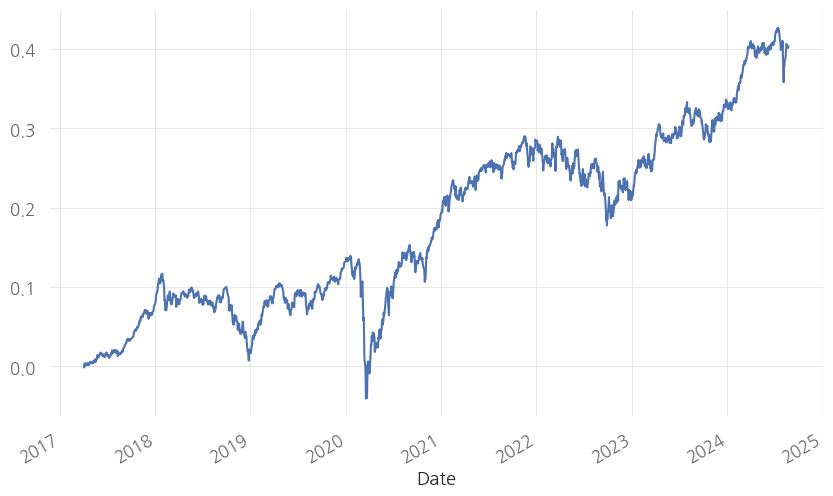

In [46]:
backtest.plot_cum_return()

In [47]:
stats = [
    'sharpe',
    'avg_return',
    'max_drawdown',
    'win_rate',
]

for stat in stats:
    print(f'{stat}: {backtest.get_stat(stat)}')

sharpe: 0.7338097535541257
avg_return: 0.0001952539925404654
max_drawdown: -0.1579015100018839
win_rate: 0.5586130985140341


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


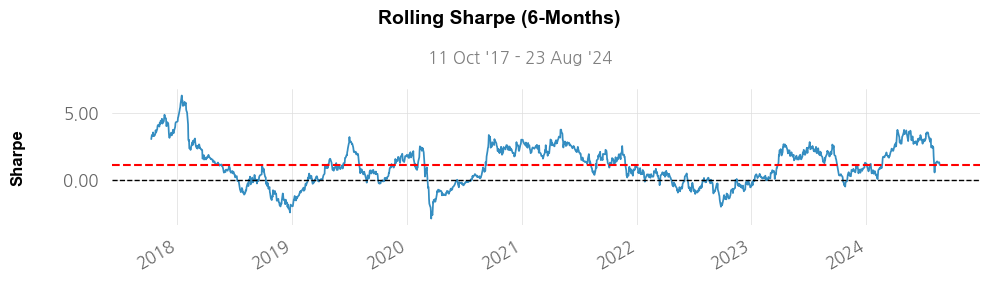

In [48]:
backtest.get_plot('rolling_sharpe')

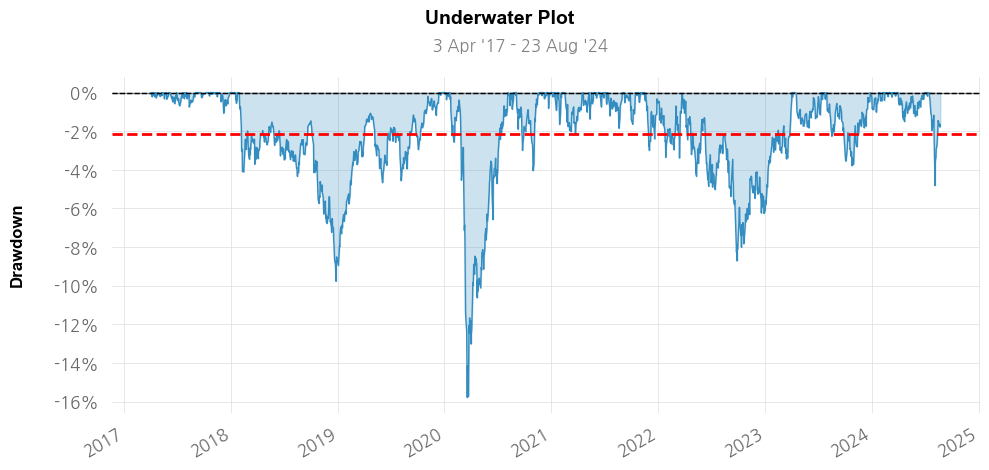

In [49]:
backtest.get_plot('drawdown')

### Momentum 3: Asset class momentum

In [54]:
group_2_assets = gcfg.GROUP_ASSETS
group_2_assets

{'kor_stock': ['kodex200', 'kosdaq150'],
 'foreign_stock': ['sp500', 'euro50', 'nikkei', 'csi300'],
 'bond': ['10y', 'midbond', 'hybond'],
 'commodity': ['gold', 'oil'],
 'inverse': ['kodexinv'],
 'fx': ['usd', 'usdinv'],
 'money': ['shortterm']}

In [66]:
def group_operation(values, groups, operation_func):
    values = np.array(values)
    groups = np.array(groups)
    
    unique_groups = np.unique(groups)
    
    results = np.zeros_like(values)
    for group in unique_groups:
        idx = np.where(groups == group)
        results[idx] = operation_func(values[idx])
    
    return results


In [67]:
asset_groups = [ 
    0, 0, 
    1, 1, 1, 1,
    2, 2, 2, 
    3, 3, 
    4, 
    5, 5, 
    6, 
    ]

In [77]:
momentum_v3 = return_df.apply(lambda row: group_operation(row, asset_groups, np.mean))

In [78]:
momentum_v3.dropna(inplace=True)

In [80]:
# apply constraint

constraint_momentum_v3 = ConstraintHandler.apply_constraints(
    weights_df=momentum_v3,
    objective_function=obj_mse,
)

In [81]:
# Alpha validation

momentum_v3_alpha = Alpha('jaepil', constraint_momentum_v3)

In [82]:
backtest = Backtest(momentum_v3_alpha, return_df)

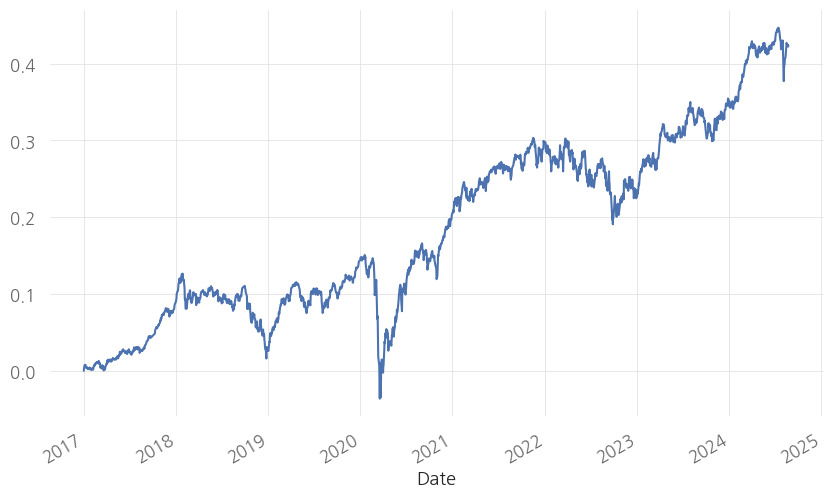

In [83]:
backtest.plot_cum_return()

In [84]:
stats = [
    'sharpe',
    'avg_return',
    'max_drawdown',
    'win_rate',
]

for stat in stats:
    print(f'{stat}: {backtest.get_stat(stat)}')

sharpe: 0.7395921847698492
avg_return: 0.0001968976597036484
max_drawdown: -0.162429235676936
win_rate: 0.5598722724853645


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


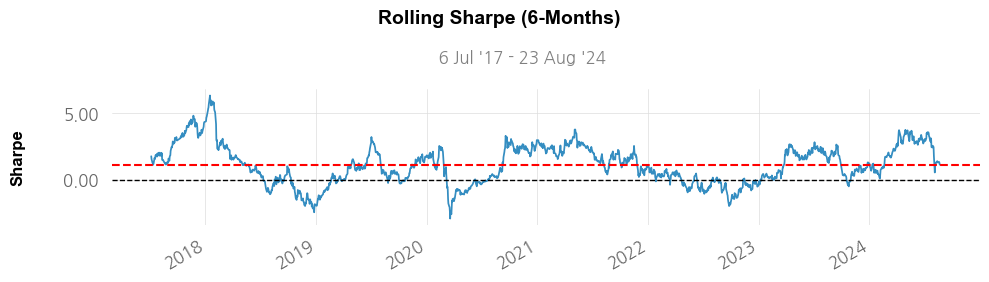

In [85]:
backtest.get_plot('rolling_sharpe')

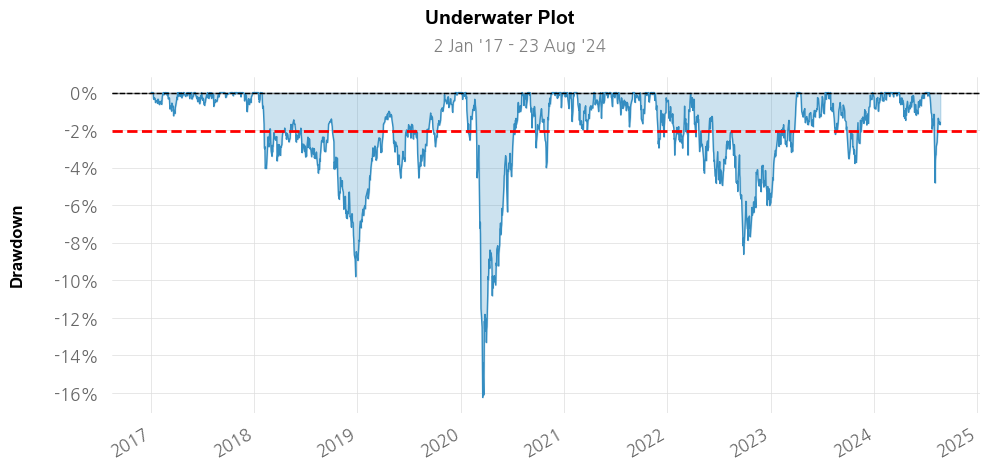

In [86]:
backtest.get_plot('drawdown')

### Momentum 4: Asset class momentum - smoothing

In [87]:
momentum_v4 = return_df.apply(lambda row: group_operation(row, asset_groups, np.mean)).rolling(63).mean()

In [88]:
momentum_v4.dropna(inplace=True)

In [89]:
# apply constraint

constraint_momentum_v4 = ConstraintHandler.apply_constraints(
    weights_df=momentum_v4,
    objective_function=obj_mse,
)

In [91]:
# Alpha validation

momentum_v4_alpha = Alpha('jaepil', constraint_momentum_v4)

In [92]:
backtest = Backtest(momentum_v4_alpha, return_df)

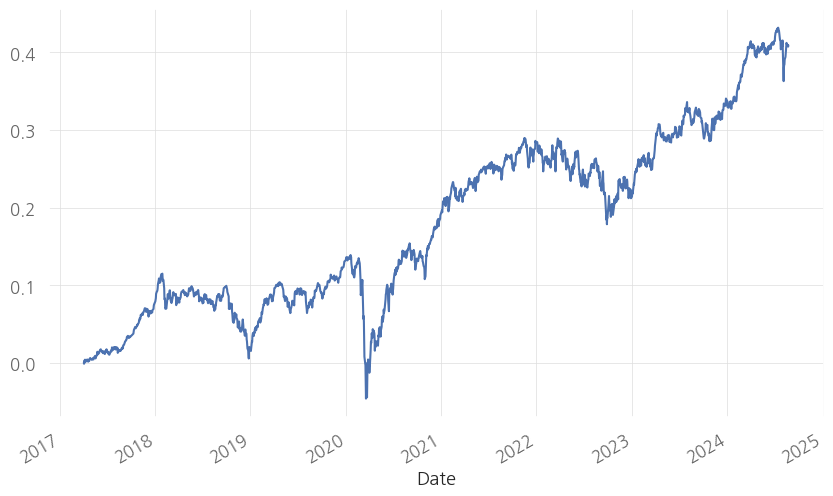

In [93]:
backtest.plot_cum_return()

In [94]:
stats = [
    'sharpe',
    'avg_return',
    'max_drawdown',
    'win_rate',
]

for stat in stats:
    print(f'{stat}: {backtest.get_stat(stat)}')

sharpe: 0.7331977770718424
avg_return: 0.0001978819820162622
max_drawdown: -0.16242923567693646
win_rate: 0.5586130985140341


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


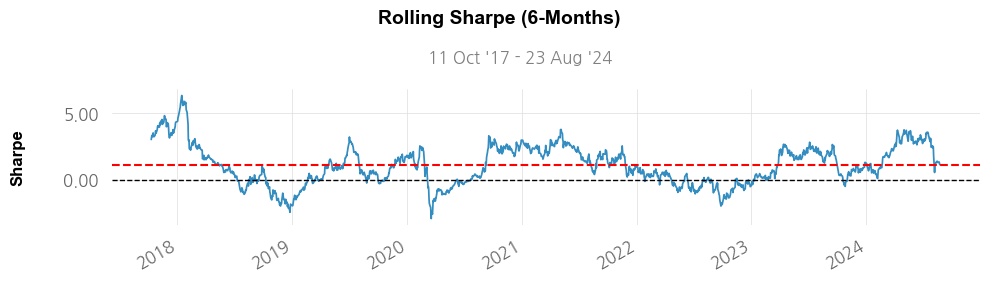

In [95]:
backtest.get_plot('rolling_sharpe')

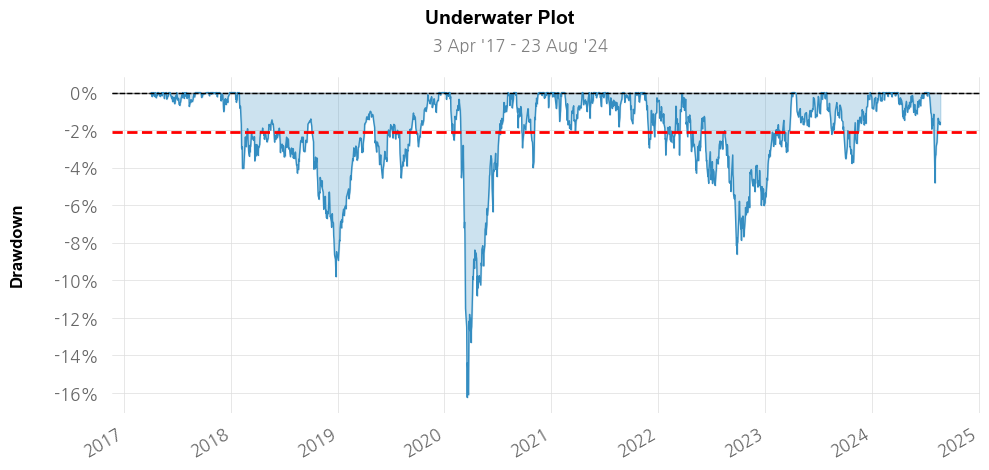

In [96]:
backtest.get_plot('drawdown')